In [1]:
import os
import cmdstanpy
from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import describe, gaussian_kde, norm, expon
import multiprocessing
import seaborn as sns
import warnings
import time
import pandas as pd
import math

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 14

In [3]:
from thinning import sample_hawkes_process_thinning_true_vectorised
from utils import exp_kernel_vectorised, constant_background, plot_counting_process
from mle import log_likelihood, optimise_params
from utils import trace_plots, posterior_histograms, posterior_kdes_overlaid, stacked_credible_intervals
from utils import process_csv_data

In [4]:
param_strings = ['mu', 'alpha', 'delta']

In [5]:
data_dir = r"C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\data_fitting\data"

In [6]:
save_dir = r"C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\data_fitting\saved_fits"

In [7]:
np.random.SeedSequence()

SeedSequence(
    entropy=206576151800868471199305446649295762155,
)

In [8]:
seed = 214370650960106687509750059852927702385

In [9]:
rng = np.random.default_rng(seed)

In [10]:
stan_seed = rng.integers(2**32 - 1)
print(stan_seed)

3207695894


In [11]:
stan_seed = 3207695894

# Guinea

In [12]:
data_file_name = "guinea_first_800.csv"

In [13]:
data_file_path = os.path.join(data_dir, data_file_name)

In [14]:
df = pd.read_csv(data_file_path)

In [15]:
df.head()

,date
0,01/01/2014
1,01/01/2014
2,06/01/2014
3,06/01/2014
4,11/01/2014


In [16]:
len(df)

806

In [17]:
date_numbers_interpolated = process_csv_data(data_file_path)

In [18]:
date_numbers_interpolated[-5:]

array([241.28571429, 241.42857143, 241.57142857, 241.71428571,
       241.85714286])

We set max_T to be the beginning of the day after the last event.

In [19]:
max_T = math.floor(date_numbers_interpolated[-1]) + 1
print(max_T)

242


In [20]:
data = date_numbers_interpolated, max_T
initial_guess = [0.5, 0.5, 0.5]
mle_params, result = optimise_params(data, initial_guess, 1e-6)

In [21]:
mle_params

array([0.34033181, 0.48300684, 0.52470629])

In [22]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -453.21643855851437
        x: [ 3.403e-01  4.830e-01  5.247e-01]
      nit: 13
      jac: [ 3.524e-04  6.708e-04 -7.390e-04]
     nfev: 60
     njev: 15
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [23]:
reproduction_estimate = mle_params[1]/mle_params[2]
print(reproduction_estimate)

0.9205280024130319


In [24]:
stan_file = os.path.join('.', 'bayesian_clean', 'models', 'exponential_priors.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

In [25]:
data = {
    "N": len(date_numbers_interpolated),
    "events_list": date_numbers_interpolated,
    "max_T": max_T             
}

In [26]:
save_path = os.path.join(save_dir, 'exponential_priors', 'guinea')

In [27]:
warmup=250
# fit = model_compiled.sample(data=data,
#                                 seed=stan_seed,
#                                 chains=2,
#                                 parallel_chains=2,
#                                 iter_warmup=warmup,
#                                 iter_sampling=3*warmup,
#                                 inits="0",
#                                 save_warmup=True,
#                                 output_dir=save_path)

In [28]:
fit = cmdstanpy.from_csv(save_path)

In [29]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,449.355000,0.052766,1.216310,447.066000,449.655000,450.730000,531.359,0.404533,0.99954
mu,0.374398,0.004135,0.100839,0.215899,0.370185,0.548237,594.713,0.452766,1.00144
alpha,0.516676,0.004286,0.090396,0.369925,0.512082,0.672152,444.902,0.338712,1.00015
delta,0.567282,0.005374,0.104396,0.398303,0.562211,0.748771,377.408,0.287328,1.00054


In [30]:
print(fit.diagnose())

Processing csv files: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\data_fitting\saved_fits\exponential_priors\guinea\exponential_priors-20240427004240_1.csvWarning: non-fatal error reading adaptation data
, C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\data_fitting\saved_fits\exponential_priors\guinea\exponential_priors-20240427004240_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [31]:
key_parameters_df = fit.draws_pd(['mu', 'alpha', 'delta', 'lp__'])

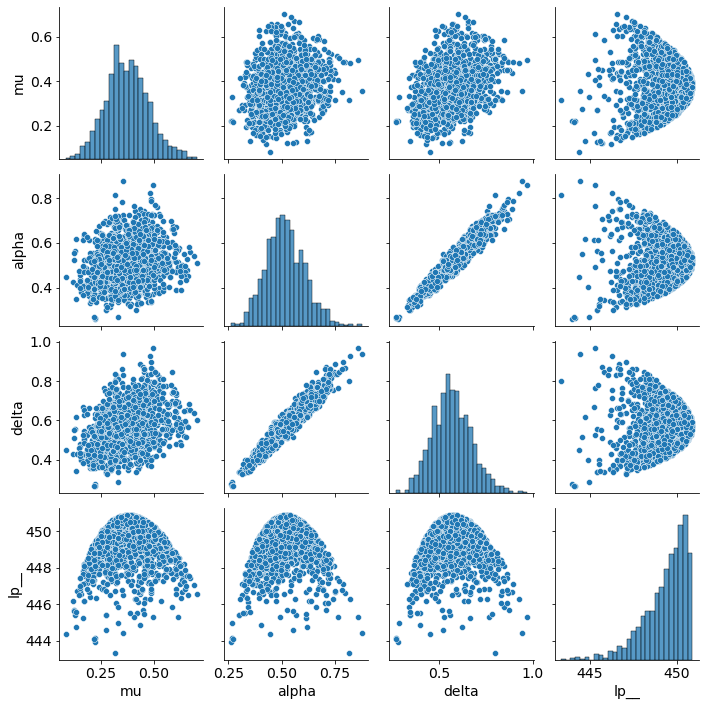

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    sns.pairplot(key_parameters_df)
plt.show()

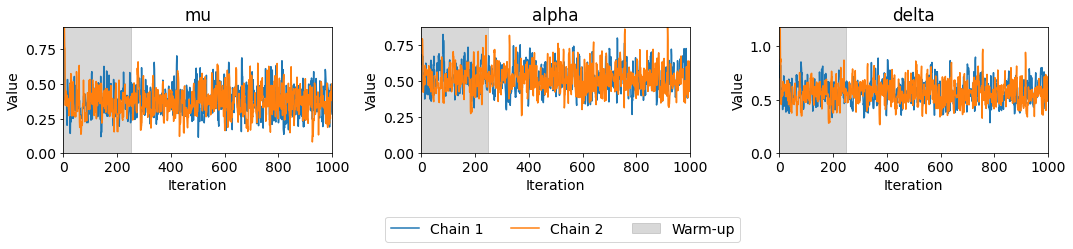

In [33]:
trace_plots([fit], param_strings, warmup=250)

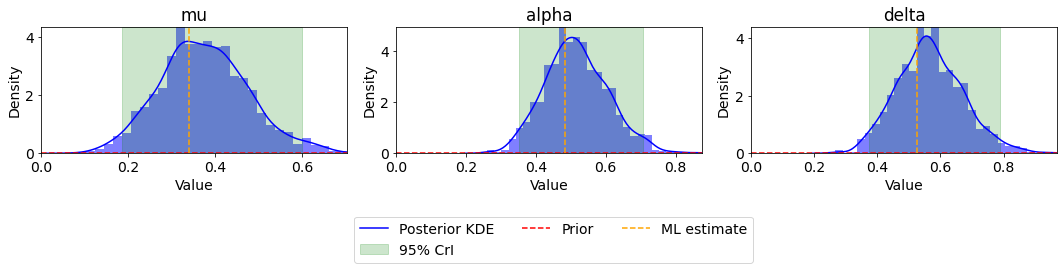

In [34]:
posterior_histograms([fit], param_strings, [lambda x: expon.pdf(x, scale=1/0.01)]*3, mles=mle_params)

In [35]:
reproduction_posterior = key_parameters_df['alpha'].values / key_parameters_df['delta'].values

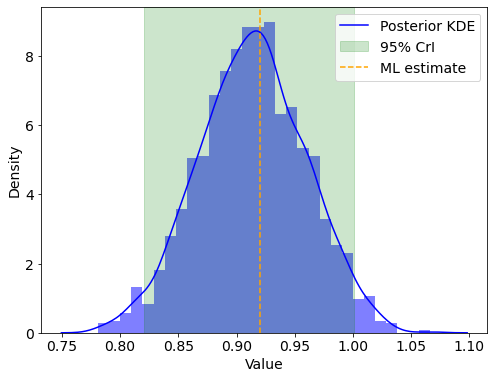

[0.82021253 1.00090956]


In [36]:
plt.figure(figsize=(8,6))
plt.hist(reproduction_posterior, bins=30, alpha=0.5, color='blue', density=True)
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    sns.kdeplot(reproduction_posterior, color='blue', label='Posterior KDE')
credible_interval = stats.mstats.mquantiles(reproduction_posterior, [0.025, 0.975])
plt.axvspan(xmin=credible_interval[0], xmax=credible_interval[1], color='green', alpha=0.2, label='95% CrI')
plt.axvline(reproduction_estimate, color='orange', linestyle='--', label='ML estimate')
plt.legend()
plt.xlabel('Value')
plt.show()
print(credible_interval)

# Liberia

In [37]:
data_file_name = "liberia_first_800.csv"

In [38]:
data_file_path = os.path.join(data_dir, data_file_name)

In [39]:
df = pd.read_csv(data_file_path)

In [40]:
df.head()

,date
0,23/02/2014
1,24/02/2014
2,28/02/2014
3,01/03/2014
4,03/03/2014


In [41]:
len(df)

805

In [42]:
date_numbers_interpolated = process_csv_data(data_file_path)

In [43]:
date_numbers_interpolated[-50:]

array([161.  , 161.02, 161.04, 161.06, 161.08, 161.1 , 161.12, 161.14,
       161.16, 161.18, 161.2 , 161.22, 161.24, 161.26, 161.28, 161.3 ,
       161.32, 161.34, 161.36, 161.38, 161.4 , 161.42, 161.44, 161.46,
       161.48, 161.5 , 161.52, 161.54, 161.56, 161.58, 161.6 , 161.62,
       161.64, 161.66, 161.68, 161.7 , 161.72, 161.74, 161.76, 161.78,
       161.8 , 161.82, 161.84, 161.86, 161.88, 161.9 , 161.92, 161.94,
       161.96, 161.98])

In [44]:
max_T = math.floor(date_numbers_interpolated[-1]) + 1
print(max_T)

162


In [45]:
data = date_numbers_interpolated, max_T
initial_guess = [0.5, 0.5, 0.5]
mle_params, result = optimise_params(data, initial_guess, 1e-6)

In [46]:
mle_params

array([0.11723153, 0.37639008, 0.32013824])

In [47]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -1325.0480764799606
        x: [ 1.172e-01  3.764e-01  3.201e-01]
      nit: 16
      jac: [ 6.821e-05  2.501e-04 -2.046e-04]
     nfev: 72
     njev: 18
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [48]:
reproduction_estimate = mle_params[1]/mle_params[2]
print(reproduction_estimate)

1.1757110694538024


In [49]:
stan_file = os.path.join('.', 'bayesian_clean', 'models', 'exponential_priors.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

In [50]:
data = {
    "N": len(date_numbers_interpolated),
    "events_list": date_numbers_interpolated,
    "max_T": max_T             
}

In [51]:
save_path = os.path.join(save_dir, 'exponential_priors', 'liberia')

In [52]:
warmup=250
# fit = model_compiled.sample(data=data,
#                                 seed=stan_seed,
#                                 chains=2,
#                                 parallel_chains=2,
#                                 iter_warmup=warmup,
#                                 iter_sampling=3*warmup,
#                                 inits="0",
#                                 save_warmup=True,
#                                 output_dir=save_path)

In [53]:
fit = cmdstanpy.from_csv(save_path)

In [54]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,1319.510000,0.056223,1.261550,1317.060000,1319.880000,1320.880000,503.474,0.241533,1.00006
mu,0.144167,0.002360,0.058427,0.057994,0.137175,0.253797,612.786,0.293974,1.00315
alpha,0.427264,0.004745,0.100628,0.282746,0.420660,0.600616,449.818,0.215792,1.00665
delta,0.373570,0.005045,0.102711,0.224549,0.365350,0.553991,414.420,0.198811,1.00744


In [55]:
print(fit.diagnose())

Processing csv files: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\data_fitting\saved_fits\exponential_priors\liberia\exponential_priors-20240427005954_1.csvWarning: non-fatal error reading adaptation data
, C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\data_fitting\saved_fits\exponential_priors\liberia\exponential_priors-20240427005954_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [56]:
key_parameters_df = fit.draws_pd(['mu', 'alpha', 'delta', 'lp__'])

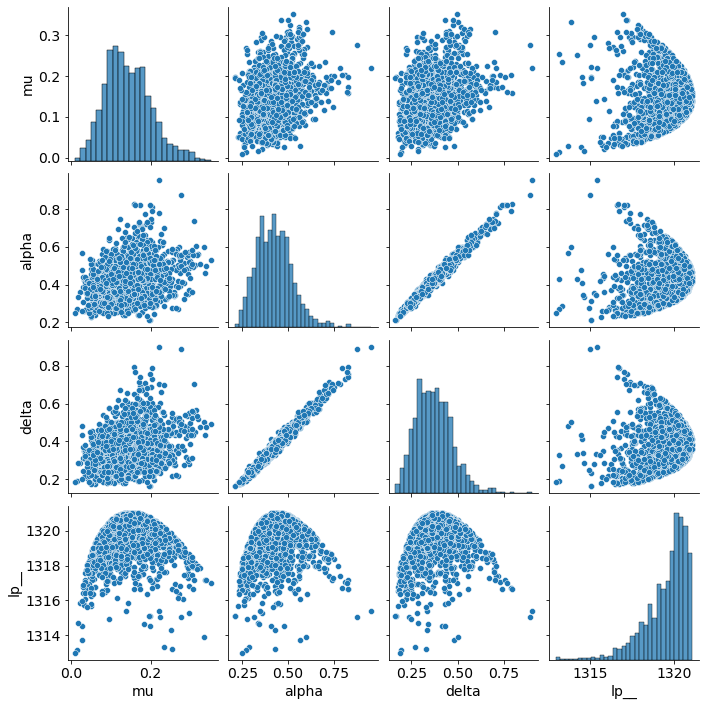

In [57]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    sns.pairplot(key_parameters_df)
plt.show()

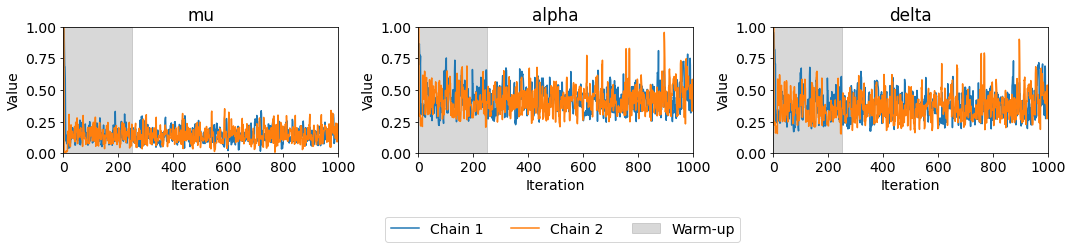

In [58]:
trace_plots([fit], param_strings, warmup=250)

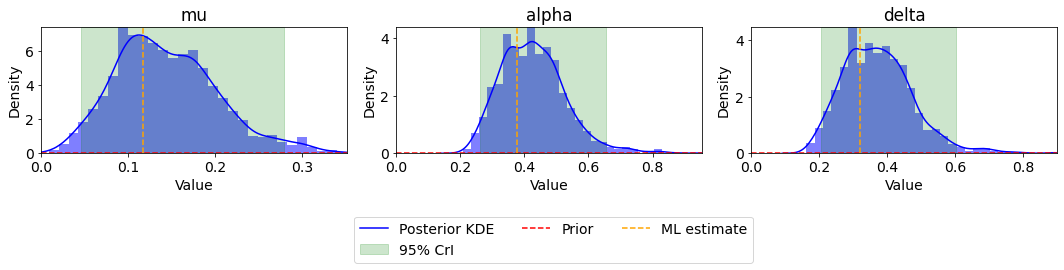

In [59]:
posterior_histograms([fit], param_strings, [lambda x: expon.pdf(x, scale=1/0.01)]*3, mles=mle_params)

In [60]:
reproduction_posterior = key_parameters_df['alpha'].values / key_parameters_df['delta'].values

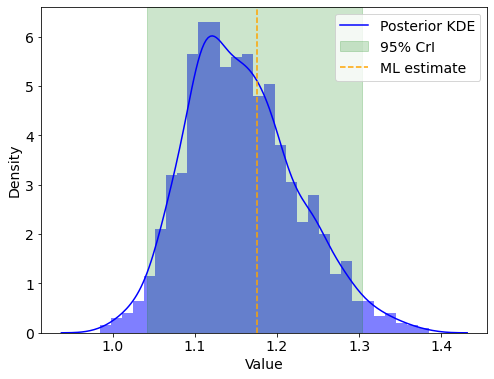

[1.04239311 1.30365045]


In [61]:
plt.figure(figsize=(8,6))
plt.hist(reproduction_posterior, bins=30, alpha=0.5, color='blue', density=True)
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    sns.kdeplot(reproduction_posterior, color='blue', label='Posterior KDE')
credible_interval = stats.mstats.mquantiles(reproduction_posterior, [0.025, 0.975])
plt.axvspan(xmin=credible_interval[0], xmax=credible_interval[1], color='green', alpha=0.2, label='95% CrI')
plt.axvline(reproduction_estimate, color='orange', linestyle='--', label='ML estimate')
plt.legend()
plt.xlabel('Value')
plt.show()
print(credible_interval)

# Sierra Leone

In [62]:
data_file_name = "sierra_leone_first_800.csv"

In [63]:
data_file_path = os.path.join(data_dir, data_file_name)

In [64]:
df = pd.read_csv(data_file_path)

In [65]:
df.head()

,date
0,26/12/2013
1,01/01/2014
2,01/01/2014
3,26/01/2014
4,15/02/2014


In [66]:
len(df)

817

In [67]:
date_numbers_interpolated = process_csv_data(data_file_path)

In [68]:
date_numbers_interpolated[-32:]

array([219.     , 219.03125, 219.0625 , 219.09375, 219.125  , 219.15625,
       219.1875 , 219.21875, 219.25   , 219.28125, 219.3125 , 219.34375,
       219.375  , 219.40625, 219.4375 , 219.46875, 219.5    , 219.53125,
       219.5625 , 219.59375, 219.625  , 219.65625, 219.6875 , 219.71875,
       219.75   , 219.78125, 219.8125 , 219.84375, 219.875  , 219.90625,
       219.9375 , 219.96875])

In [69]:
max_T = math.floor(date_numbers_interpolated[-1]) + 1
print(max_T)

220


In [70]:
data = date_numbers_interpolated, max_T
initial_guess = [0.5, 0.5, 0.5]
mle_params, result = optimise_params(data, initial_guess, 1e-6)

In [71]:
mle_params

array([0.09727291, 0.44794132, 0.42783616])

In [72]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -1082.2013667243345
        x: [ 9.727e-02  4.479e-01  4.278e-01]
      nit: 9
      jac: [-1.364e-04 -4.547e-04  5.457e-04]
     nfev: 60
     njev: 15
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [73]:
reproduction_estimate = mle_params[1]/mle_params[2]
print(reproduction_estimate)

1.0469926618584644


In [74]:
stan_file = os.path.join('.', 'bayesian_clean', 'models', 'exponential_priors.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

In [75]:
data = {
    "N": len(date_numbers_interpolated),
    "events_list": date_numbers_interpolated,
    "max_T": max_T             
}

In [76]:
save_path = os.path.join(save_dir, 'exponential_priors', 'sierra_leone')

In [77]:
warmup=250
# fit = model_compiled.sample(data=data,
#                                 seed=stan_seed,
#                                 chains=2,
#                                 parallel_chains=2,
#                                 iter_warmup=warmup,
#                                 iter_sampling=3*warmup,
#                                 inits="0",
#                                 save_warmup=True,
#                                 output_dir=save_path)

In [78]:
fit = cmdstanpy.from_csv(save_path)

In [79]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,1076.810000,0.076141,1.330340,1074.060000,1077.150000,1078.230000,305.278,0.157674,1.00695
mu,0.108180,0.001460,0.034540,0.055950,0.105893,0.171005,559.641,0.289051,1.00157
alpha,0.501916,0.005933,0.121839,0.322388,0.492624,0.717461,421.707,0.217808,1.00279
delta,0.482863,0.006015,0.123449,0.300035,0.474255,0.702363,421.247,0.217571,1.00266


In [80]:
print(fit.diagnose())

Processing csv files: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\data_fitting\saved_fits\exponential_priors\sierra_leone\exponential_priors-20240427012526_1.csvWarning: non-fatal error reading adaptation data
, C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\data_fitting\saved_fits\exponential_priors\sierra_leone\exponential_priors-20240427012526_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [81]:
key_parameters_df = fit.draws_pd(['mu', 'alpha', 'delta', 'lp__'])

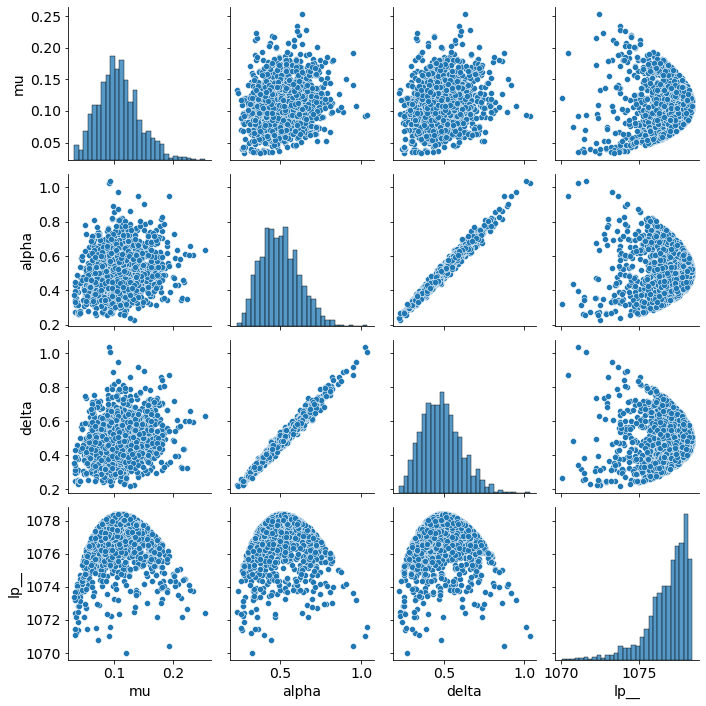

In [82]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    sns.pairplot(key_parameters_df)
plt.show()

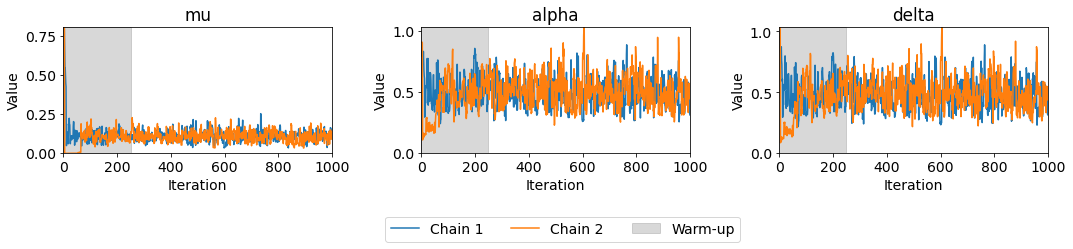

In [83]:
trace_plots([fit], param_strings, warmup=250)

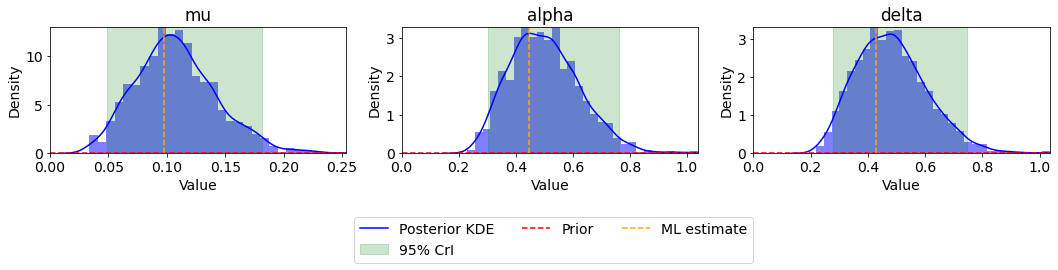

In [84]:
posterior_histograms([fit], param_strings, [lambda x: expon.pdf(x, scale=1/0.01)]*3, mles=mle_params)

In [85]:
reproduction_posterior = key_parameters_df['alpha'].values / key_parameters_df['delta'].values

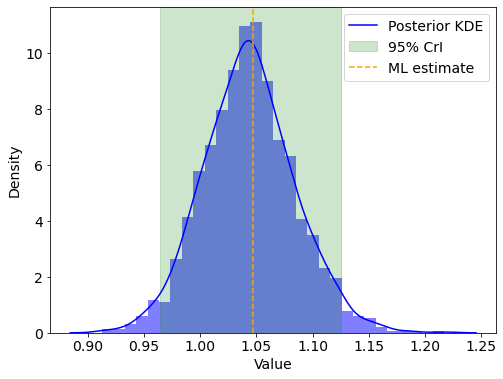

[0.96467571 1.12527772]


In [86]:
plt.figure(figsize=(8,6))
plt.hist(reproduction_posterior, bins=30, alpha=0.5, color='blue', density=True)
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    sns.kdeplot(reproduction_posterior, color='blue', label='Posterior KDE')
credible_interval = stats.mstats.mquantiles(reproduction_posterior, [0.025, 0.975])
plt.axvspan(xmin=credible_interval[0], xmax=credible_interval[1], color='green', alpha=0.2, label='95% CrI')
plt.axvline(reproduction_estimate, color='orange', linestyle='--', label='ML estimate')
plt.legend()
plt.xlabel('Value')
plt.show()
print(credible_interval)